<a href="https://colab.research.google.com/github/supertime1/OSA/blob/main/sleep_staging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Import Dependency

In [1]:
!pip install mne

In [1]:
import os
import mne
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import pickle
import tensorflow as tf
import sklearn
from sklearn import metrics
import itertools
import io
import datetime
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import load_model 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, BatchNormalization, Input, Add, Activation,\
MaxPooling1D,Dropout,Flatten,TimeDistributed,Bidirectional,Dense,LSTM, ZeroPadding1D, \
AveragePooling1D,GlobalMaxPooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector,\
Lambda, Average, Softmax
from tensorflow.keras.initializers import glorot_uniform
import tensorflow_datasets as tfds

# Load the TensorBoard notebook extension
%load_ext tensorboard

###TPU

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

###GPU

In [2]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


#2.Process the data

##2.1 Local preprocess

In [7]:
def load_data(file_path, sf=128, epoch_duration=30):

    ecg_samples = []
    ecg_labels = []
    total_epoches = 0
    
    for signal_file in glob.glob(file_path + '*[0-9].edf'):
        
        ecg_epoches = []
        
        data = mne.io.read_raw_edf(signal_file)
        ecg_ch = [i for i, v in enumerate(data.info.ch_names) if v == 'ECG']
        ecg_signal = data.get_data()[ecg_ch[0]]
        
        num_of_sample_per_epoch = sf * epoch_duration
        num_of_epoches = len(ecg_signal) // (num_of_sample_per_epoch)
        total_epoches += num_of_epoches
        
        print(f'{signal_file[-12:]} has {num_of_epoches} epoches')

        for i in range(num_of_epoches):
            ecg_epoch = ecg_signal[i*num_of_sample_per_epoch : (i+1)*num_of_sample_per_epoch]
            ecg_epoches.append(ecg_epoch)
        ecg_samples.append(ecg_epoches)
    
    for label_file in glob.glob(file_path + '*stage.txt'):
        print(f'reading {label_file}')
        ecg_labels.append(np.loadtxt(label_file))
        
    assert len(ecg_samples) == len(ecg_labels)

    for i in range(len(ecg_samples)):
        new_length = len(ecg_labels[i])
        ecg_samples[i] = ecg_samples[i][:new_length]
    
    return ecg_samples, ecg_labels, total_epoches

fp = "C:/Users/57lzhang.US04WW4008/Downloads/ucd/files/"
ecg_samples, ecg_labels, total_epoches = load_data(fp, 128, 30)

In [8]:
with open("C:/Users/57lzhang.US04WW4008/Downloads/ucd/files/processed_data/ecg_samples.pkl", "wb") as fp:
    pickle.dump(ecg_samples, fp)

with open("C:/Users/57lzhang.US04WW4008/Downloads/ucd/files/processed_data/ecg_labels.pkl", "wb") as fp:
    pickle.dump(ecg_labels, fp)

FileNotFoundError: ignored

##2.2 Load data from Cloud

In [3]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/osa/ecg_samples.pkl'

with open('/content/drive/MyDrive/osa/ecg_samples.pkl', "rb") as fp:
    ecg_samples = pickle.load(fp)

with open('/content/drive/MyDrive/osa/ecg_labels.pkl', "rb") as fp:
    ecg_labels = pickle.load(fp)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# split by patient id 
def split_data(ecg_samples, ecg_labels, train_ratio, test_ratio):
    test_num = round(len(ecg_samples) * test_ratio)
    train_num = round((len(ecg_samples) - test_num) * train_ratio)
    val_num = len(ecg_samples) - test_num - train_num

    np.random.seed(seed=7)
    np.random.shuffle(ecg_samples)
    train_samples = ecg_samples[:train_num]
    val_samples = ecg_samples[train_num:train_num+val_num]
    test_samples = ecg_samples[-test_num:]

    np.random.seed(seed=7)
    np.random.shuffle(ecg_labels)
    train_labels = ecg_labels[:train_num]
    val_labels = ecg_labels[train_num:train_num+val_num]
    test_labels = ecg_labels[-test_num:]

    return train_samples, train_labels, val_samples, val_labels, test_samples, test_labels 

train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = split_data(ecg_samples, ecg_labels, 0.8, 0.12)
print(f'There are {len(train_samples)} subjects in training dataset')
print(f'There are {len(val_samples)} subjects in validation dataset')
print(f'There are {len(test_samples)} subjects in testing dataset')

There are 18 subjects in training dataset
There are 4 subjects in validation dataset
There are 3 subjects in testing dataset


In [5]:
def preprocess_data(num_epoch, epoch_duration, sf, ecg_samples, ecg_labels, oversample=True):
    """
    preprocess data with the matched dimension for training
    [num_epoch, 30*sampling_frequency, 1]

    params:
    epoch - number of epoches for each training sample
    sf - sampling frequency of ECG signal
    file_path - file path of raw EDF file
    """
    model_signal_input = []
    model_label_input = []

    num_of_sample_per_epoch = sf * epoch_duration

    for i in range(len(ecg_samples)):
        ecg_samples[i] = sklearn.preprocessing.minmax_scale(ecg_samples[i])
        if oversample:
            overlap = int(0.9 * num_epoch)
            for j in range(len(ecg_samples[i])):
                signal_segment = np.asarray(ecg_samples[i][j*(num_epoch - overlap): j*(num_epoch - overlap) + num_epoch])
                if len(signal_segment) == num_epoch:
                    new_signal_seg = np.reshape(signal_segment, (num_epoch, num_of_sample_per_epoch, 1))
                    model_signal_input.append(new_signal_seg)
                
                # apply to labels as well
                label_segment = np.asarray(ecg_labels[i][j*(num_epoch - overlap): j*(num_epoch - overlap) + num_epoch])
                if len(label_segment) == num_epoch:
                    model_label_input.append(label_segment)
        
        else:
            for j in range(len(ecg_samples[i])):
                signal_segment = np.asarray(ecg_samples[i][j*num_epoch: (j+1)*num_epoch]) 
                if len(signal_segment) == num_epoch:
                    new_signal_seg = np.reshape(signal_segment, (num_epoch, num_of_sample_per_epoch, 1))
                    model_signal_input.append(new_signal_seg)

                # apply to labels as well
                label_segment = np.asarray(ecg_labels[i][j*num_epoch: (j+1)*num_epoch])
                if len(label_segment) == num_epoch:
                    model_label_input.append(label_segment)
        
    print(f'shape of processed signal data: {np.asarray(model_signal_input).shape}')
    print(f'shape of processed label data: {np.asarray(model_label_input).shape}')

    return np.asarray(model_signal_input), np.asarray(model_label_input)

In [6]:
def helper(samples, labels):
    for i in range(len(samples)):
        print(f'{len(samples[i])}, {len(labels[i])}')

helper(ecg_samples, ecg_labels)

882, 882
768, 768
774, 774
789, 789
826, 826
711, 711
864, 864
752, 752
916, 916
748, 748
893, 893
925, 925
908, 908
913, 913
721, 721
811, 811
787, 787
900, 900
822, 822
907, 907
861, 861
808, 808
838, 838
813, 813
852, 852


In [7]:
train_signal_input, train_label_input = preprocess_data(50, 30, 128, train_samples, train_labels, oversample=True)
val_signal_input, val_label_input = preprocess_data(50, 30, 128, val_samples, val_labels, oversample=True)
test_signal_input, test_label_input = preprocess_data(50, 30, 128, test_samples, test_labels, oversample=False)

shape of processed signal data: (2808, 50, 3840, 1)
shape of processed label data: (2808, 50)
shape of processed signal data: (642, 50, 3840, 1)
shape of processed label data: (642, 50)
shape of processed signal data: (49, 50, 3840, 1)
shape of processed label data: (49, 50)


In [8]:
def print_label(label_input):
    print(f'There are {len(label_input[label_input == 0])} wake labels')
    print(f'There are {len(label_input[label_input == 1])} REM labels')
    print(f'There are {len(label_input[label_input == 2])} Stage_1 labels')
    print(f'There are {len(label_input[label_input == 3])} Stage_2 labels')
    print(f'There are {len(label_input[label_input == 4])} Stage_3 labels')
    print(f'There are {len(label_input[label_input == 5])} Stage_4 labels')
    print(f'There are {len(label_input[label_input == 6])} Artifact labels')
    print(f'There are {len(label_input[label_input == 7])} Indeterminate labels \n')

print_label(train_label_input)
print_label(val_label_input)
print_label(test_label_input)

There are 30608 wake labels
There are 19753 REM labels
There are 25226 Stage_1 labels
There are 48120 Stage_2 labels
There are 4476 Stage_3 labels
There are 12083 Stage_4 labels
There are 0 Artifact labels
There are 0 Indeterminate labels 

There are 6510 wake labels
There are 4283 REM labels
There are 5639 Stage_1 labels
There are 10350 Stage_2 labels
There are 1018 Stage_3 labels
There are 4300 Stage_4 labels
There are 0 Artifact labels
There are 0 Indeterminate labels 

There are 256 wake labels
There are 536 REM labels
There are 189 Stage_1 labels
There are 1007 Stage_2 labels
There are 115 Stage_3 labels
There are 347 Stage_4 labels
There are 0 Artifact labels
There are 0 Indeterminate labels 



In [9]:
def join_labels(label_input):
    for i in range(len(label_input)):
        label_input[label_input > 1] = 2
    print(f'There are {len(label_input[label_input == 0])} wake labels')
    print(f'There are {len(label_input[label_input == 1])} REM labels')
    print(f'There are {len(label_input[label_input == 2])} NREM labels \n')
    return label_input

In [10]:
train_label_input_join = join_labels(train_label_input)
val_label_input_join = join_labels(val_label_input)
test_label_input_join = join_labels(test_label_input)

There are 30608 wake labels
There are 19753 REM labels
There are 90039 NREM labels 

There are 6510 wake labels
There are 4283 REM labels
There are 21307 NREM labels 

There are 256 wake labels
There are 536 REM labels
There are 1658 NREM labels 



In [11]:
def oversample_label(train_signal_input, train_label_input_join):
    os_train_signal_input = []
    os_train_label_input_join = []
    
    for i in range(len(train_label_input_join)):
        if len(train_label_input_join[i][train_label_input_join[i] == 1]) > 20:
            for _ in range(4):
                os_train_signal_input.append(train_signal_input[i])
                os_train_label_input_join.append(train_label_input_join[i])
        
        os_train_signal_input.append(train_signal_input[i])
        os_train_label_input_join.append(train_label_input_join[i])

    os_train_signal = np.asarray(os_train_signal_input)
    os_train_label = np.asarray(os_train_label_input_join)

    print(f'There are {len(os_train_label[os_train_label == 0])} wake labels')
    print(f'There are {len(os_train_label[os_train_label == 1])} REM labels')
    print(f'There are {len(os_train_label[os_train_label == 2])} NREM labels \n')
    print(f'shape of input signal {os_train_signal.shape}')
    return os_train_signal, os_train_label

In [12]:
os_train_signal, os_train_label = oversample_label(train_signal_input, train_label_input_join)

There are 35188 wake labels
There are 81493 REM labels
There are 112719 NREM labels 

shape of input signal (4588, 50, 3840, 1)


#3.Model

##3.1 Callbacks

In [19]:
## tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

## checkpoint callback
filepath = os.path.join("models",  "test-oversample-128Hz-{epoch:02d}-{loss:.4f}")
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

## early stop
def decay(epoch):
    if epoch < 50:
        return 1e-3
    elif 50 <= epoch < 150:
        return 1e-4
    else:
        return 1e-5

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, 
                                              restore_best_weights=True)

## learning rate decay callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(decay)

callbacks_list = [tensorboard_callback, checkpoint, early_stop, lr_schedule]

##3.2 Model

###3.2.1 CNN+LSTM

In [17]:
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((os_train_signal, os_train_label))
val_dataset = tf.data.Dataset.from_tensor_slices((val_signal_input, val_label_input_join))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(1024).repeat().batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.repeat().batch(batch_size, drop_remainder=True)

In [17]:
def cnn_1d(input_shape=None, dropout=0.2):
    
    x_input = Input(shape=input_shape)
    x = Conv1D(64, 21, strides=5, activation='relu')(x_input)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Dropout(dropout)(x)
    # 2nd Conv1D
    x = Conv1D(128, 5, strides=1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Dropout(dropout)(x)
    # 3rd Conv1D
    x = Conv1D(256, 5, strides=1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Dropout(dropout)(x)
    # 4th Conv1D
    x = Conv1D(512, 5, strides=1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Dropout(dropout)(x)
    # 5th Conv1D
    x = Conv1D(256, 5, strides=1, activation='relu')(x)
    x = BatchNormalization()(x)

    # Full connection layer
    out = Flatten()(x)

    model = Model(x_input, out, name='cnn_1d_layer')

    return model

In [15]:
def cnn_lstm(input_shape=(50,3840,1), classes=3):
    cnn = cnn_1d((3840,1))
    x_input = Input(shape=input_shape)
    x = TimeDistributed(cnn)(x_input)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    out = TimeDistributed(Dense(classes))(x)
    model = Model(x_input, out, name='cnn_lstm')

    return model

model = cnn_lstm(input_shape=(50,3840,1), classes=3)
model.summary()

Model: "cnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 3840, 1)]     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 10240)         1522944   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 128)           5276160   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 64)            41216     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 3)             195       
Total params: 6,840,515
Trainable params: 6,838,083
Non-trainable params: 2,432
_________________________________________________________________


###3.2.2 Attention

In [13]:
n_a = 32 #Number of pre-LSTM states
n_s = 16 #Number of post-LSTM states
Tx = 50
Ty = 50
t_s0 = np.zeros((len(os_train_signal), n_s))
t_c0 = np.zeros((len(os_train_signal), n_s))
v_s0 = np.zeros((len(val_signal_input), n_s))
v_c0 = np.zeros((len(val_signal_input), n_s))

In [14]:
batch_size = 32
# training data pipeline
train_ds = tf.data.Dataset.from_tensor_slices(os_train_signal)
train_lb = tf.data.Dataset.from_tensor_slices(os_train_label)
train_s0 = tf.data.Dataset.from_tensor_slices(t_s0)
train_c0 = tf.data.Dataset.from_tensor_slices(t_c0)
train_dataset = tf.data.Dataset.zip(((train_ds,train_s0,train_c0),train_lb))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(1024).repeat().batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# validation data pipeline
val_ds = tf.data.Dataset.from_tensor_slices(val_signal_input)
val_lb = tf.data.Dataset.from_tensor_slices(val_label_input_join)
val_s0 = tf.data.Dataset.from_tensor_slices(v_s0)
val_c0 = tf.data.Dataset.from_tensor_slices(v_c0)
val_dataset = tf.data.Dataset.zip(((val_ds,val_s0,val_c0),val_lb))

val_dataset = val_dataset.repeat().batch(batch_size, drop_remainder=True)

In [22]:
train_dataset

<PrefetchDataset shapes: (((32, 50, 3840, 1), (32, 16), (32, 16)), (32, 50)), types: ((tf.float64, tf.float64, tf.float64), tf.float64)>

In [18]:
def one_step_attention(a, s_prev): 
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.

    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)

    Returns:
    context -- context vector, input of the next (post-attention) LSTM cell
    """
    s_prev = RepeatVector(Tx)(s_prev)
    concat = Concatenate(axis=-1)([a, s_prev])
    e = Dense(10, activation = "tanh")(concat)
    energies = Dense(1, activation = "relu")(e)
    alphas = tf.nn.softmax(energies,axis=1)
    context = Dot(axes = 1)([alphas,a])

    return context

In [32]:
def Resnet18_Attention(Tx, Ty, n_a, n_s, classes, input_image_size):

    X_input = Input(shape = (Tx, input_image_size, 1))
    
    cnn = cnn_1d((3840,1))

    #define Resnet-18 
    X = TimeDistributed(cnn)(X_input)

    s0 = Input(shape = (n_s, ), name = 's0')
    c0 = Input(shape = (n_s, ), name = 'c0')
    s = s0
    c = c0

    #Initialize empty list of outputs
    outputs = []

    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)

    for t in range(Ty):
        context = one_step_attention(a, s)
        s, _, c = LSTM(n_s, return_state=True)(context, initial_state=[s, c])
        out = Dense(classes)(s)
        outputs.append(out)

    model = Model(inputs=(X_input, s0, c0), outputs=outputs)

    return model

classes = 3
input_image_size = 3840
resnet18_attention = Resnet18_Attention(Tx, Ty, n_a, n_s, classes, input_image_size)
resnet18_attention.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 50, 3840, 1) 0                                            
__________________________________________________________________________________________________
time_distributed_8 (TimeDistrib (None, 50, 10240)    1522944     input_18[0][0]                   
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 16)]         0                                            
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 50, 64)       2629888     time_distributed_8[0][0]         
____________________________________________________________________________________________

##3.3 Training

In [25]:
class CustomizedLoss(tf.keras.losses.Loss):
    def compute_loss(self, logits, positions):
        one_hot_positions = tf.one_hot(
            int(positions), depth=3)
        log_probs = tf.nn.log_softmax(logits, axis=-1)
        weight = tf.constant([1.,4.,1.])
        loss = -tf.reduce_mean(
            tf.reduce_sum(one_hot_positions * log_probs * weight, axis=-1))
        return loss
    
    def call(self, y_true, y_pred):
        loss = self.compute_loss(y_pred, y_true)
        return loss

###3.3.1 Train with distributed TPUs/GPUs

In [20]:
with mirrored_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    
    model = resnet18_attention = Resnet18_Attention(Tx, Ty, n_a, n_s, 3, 3840)

    ## early stop
    def decay(epoch):
        if epoch < 50:
            return 1e-4
        elif 50 <= epoch < 150:
            return 1e-5
        else:
            return 1e-6

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

    ## learning rate decay callback
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(decay)

    callbacks_list = [early_stop, lr_schedule]

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    history = model.fit(train_dataset,
                        epochs=100,
                        steps_per_epoch=len(os_train_signal)//batch_size,
                        verbose=1,
                        validation_data=val_dataset,
                        validation_steps=len(val_signal_input)//batch_size,
                        callbacks=callbacks_list
                        )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

ValueError: ignored

In [27]:
# Retrieve a list of list results on training and test data sets for each training epoch
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(loss)) # Get number of epochs

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and validation Loss')
plt.legend()
plt.figure()

NameError: ignored

###3.3.2 Train with single TPU/GPU

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=CustomizedLoss(),
              metrics=['accuracy'])

In [ ]:
%tensorboard --logdir logs

In [ ]:
from tensorboard import notebook
notebook.display(port=6006, height=1000) 

In [ ]:
model.fit(train_dataset,
          epochs=100,
          steps_per_epoch=len(os_train_label)//batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=len(val_signal_input)//batch_size,
          callbacks=callbacks_list
          )

#4.Evaluate Model

In [19]:
# make predcitions
val_pred_raw = model.predict(val_signal_input)
val_pred = np.argmax(val_pred_raw, axis=-1)

##4.1 Confusion Matrix

In [21]:
def plot_confusion_matrix(cm, class_names, normalize=False):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.ylim(bottom=-0.5, top=2.5)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 1.5

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

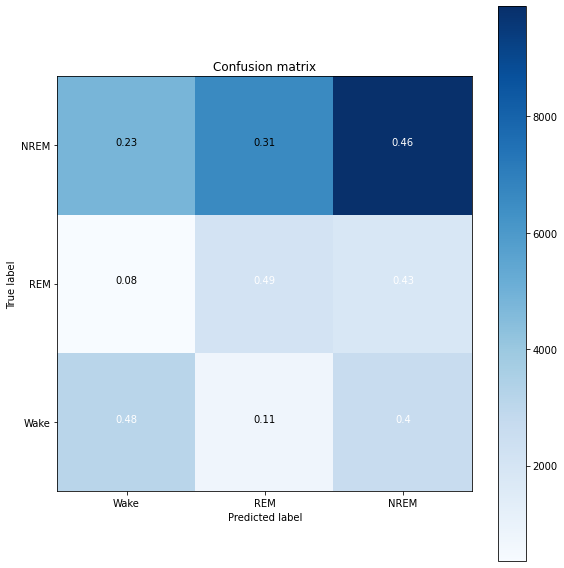

In [22]:
class_names = ['Wake','REM','NREM']
cm = sklearn.metrics.confusion_matrix(val_label_input_join.flatten(), val_pred.flatten())
plot_confusion_matrix(cm, class_names=class_names, normalize=True)

##4.2 Cohen’s kappa coefficient

In [ ]:
sklearn.metrics.cohen_kappa_score(val_label_input_join.flatten(), val_pred.flatten())

0.28901251808963335

##4.3 Clinical parameters

In [ ]:
# total sleep time
# sleep efficiency
# sleep stage percentage
# AHI